In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from nsdmd import utils
from nsdmd import nsdmd

In [2]:
from scipy.io import netcdf_file

In [3]:
with netcdf_file('/nas_data/john_scratch/nsdmd_sst_data/lsmask.nc') as f:
    temp = f.variables['mask']
    mask = (temp[:]*1)[0]

/usr/local/lib/python3.8/dist-packages/scipy/io/_netcdf.py:305: RuntimeWarning: Cannot close a netcdf_file opened with mmap=True, when netcdf_variables or arrays referring to its data still exist. All data arrays obtained from such files refer directly to data on disk, and must be copied before the file can be cleanly closed. (See netcdf_file docstring for more information on mmap.)
  warnings.warn((


# What does the data look like?

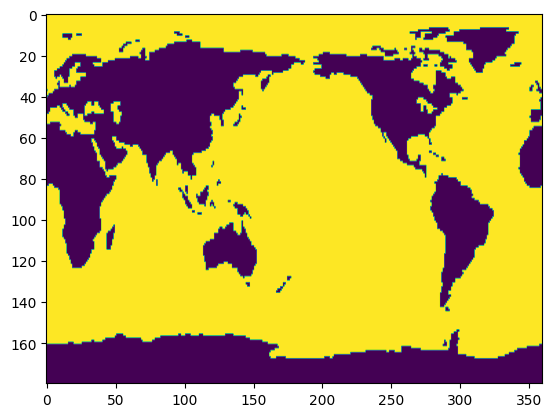

In [4]:
plt.imshow(mask, aspect='auto')

In [5]:
with netcdf_file('/nas_data/john_scratch/nsdmd_sst_data/sst.wkmean.1990-present.nc') as f:
    temp = f.variables['sst']
    sst = (temp[:]*1)

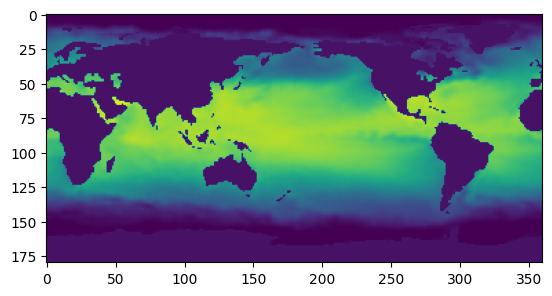

In [6]:
plt.imshow(sst[30]*mask)

# What are the dates?

In [7]:
x = sst.copy()
x = scipy.stats.zscore(x, axis=0)

sr = 365.25/7
t = np.arange(x.shape[0]) / sr

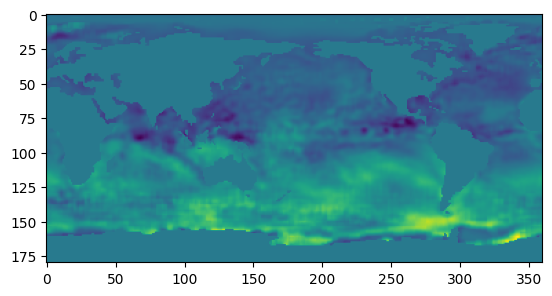

In [8]:
plt.imshow(x[0]*mask)

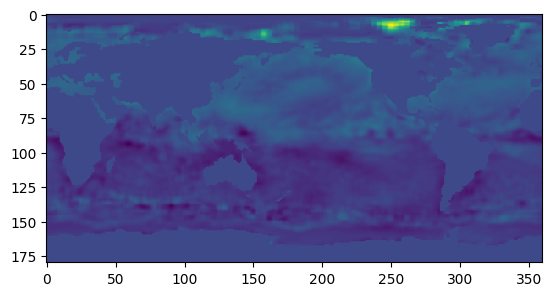

In [9]:
plt.imshow(x[26]*mask)

## Double check with specific spot

Text(0, 0.5, 'SST for N Hemisphere')

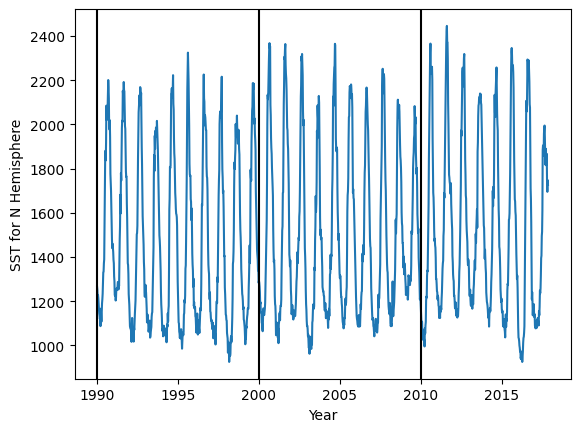

In [10]:
plt.plot(t+1990, sst[:,50,200])
for line in [1990,2000,2010]:
    plt.axvline(line, color='black')
plt.xlabel('Year')
plt.ylabel('SST for N Hemisphere')

Text(0, 0.5, 'SST for S Hemisphere')

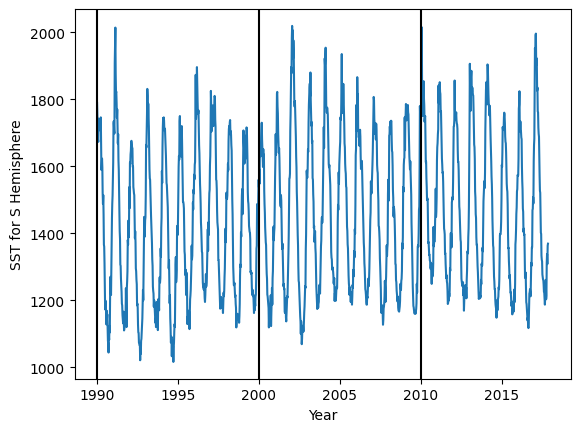

In [11]:
plt.plot(t+1990, sst[:,130,200])
for line in [1990,2000,2010]:
    plt.axvline(line, color='black')
plt.xlabel('Year')
plt.ylabel('SST for S Hemisphere')

# What does El Nino look like?

In [12]:
x = sst.copy()
x = scipy.stats.zscore(x, axis=0)

sr = 365.25/7
t = np.arange(x.shape[0]) / sr

In [13]:
temp = x[(t>8)][:4*12:4]
temp_t = t[(t>8)][:4*12:4]+1990

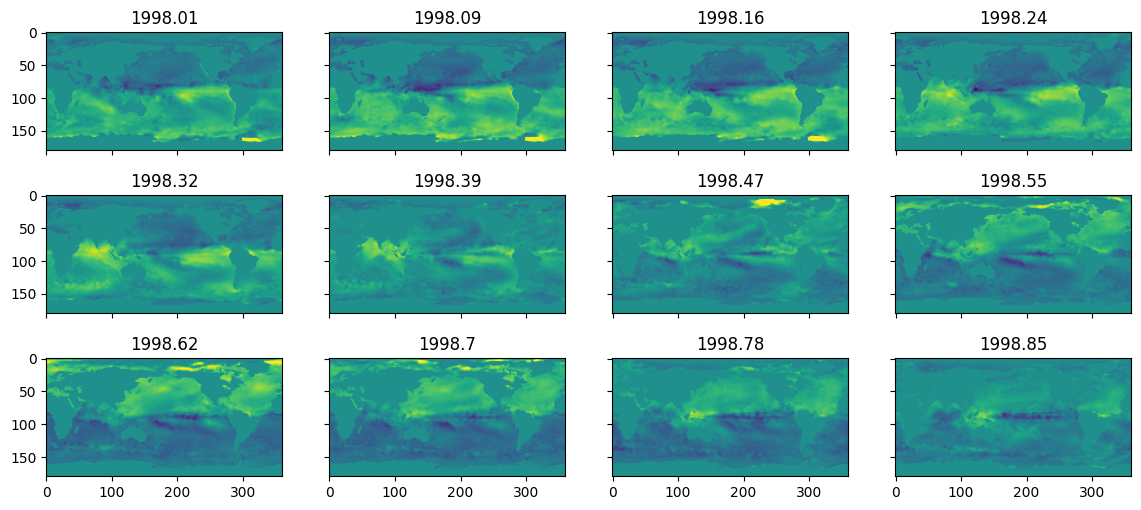

In [14]:
fig, ax = plt.subplots(3, 4, figsize=(14,6), sharex=True, sharey=True)

norm = 5

for i in range(3):
    for j in range(4):
        idx = j+4*i
        ax[i,j].imshow(
            temp[idx]*mask,
            vmin=-np.max(np.abs(temp))/norm,
            vmax=np.max(np.abs(temp))/norm
        )
        ax[i,j].set_title(str(round(temp_t[idx],2)))

# Linearize Data

In [15]:
x = sst.copy().reshape((len(sst), -1)).T
mask_1d = mask.reshape((-1))

idx_not_land = mask_1d==1
x = x[idx_not_land]

x_mean = np.mean(x, axis=1)
x_std = np.std(x, axis=1)
# Z score x
x = (x - x_mean[:,None]) / x_std[:,None]

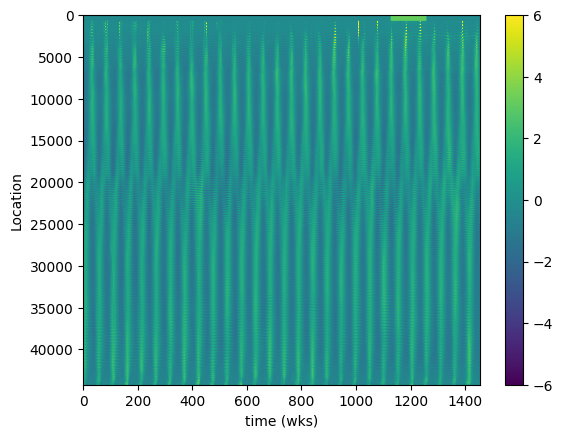

In [16]:
plt.imshow(x, aspect='auto', vmin=-6, vmax=6)
plt.xlabel('time (wks)')
plt.ylabel('Location')
plt.colorbar()

Text(0, 0.5, 'PSD')

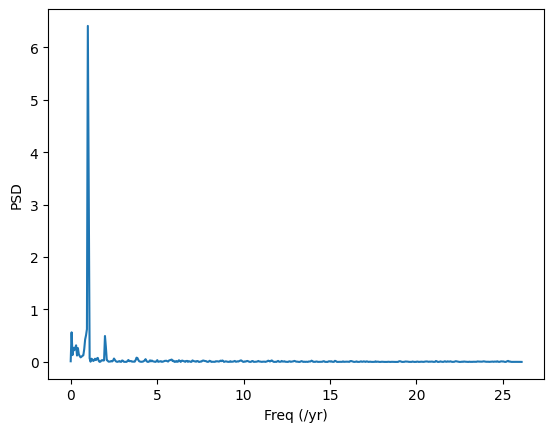

In [17]:
psd_f, psd_p = scipy.signal.welch(x[20000], fs=sr, nperseg=1000)
plt.plot(psd_f, psd_p)
# plt.xlim(0,4)
plt.xlabel('Freq (/yr)')
plt.ylabel('PSD')

In [18]:
x = x[:,:1400]
t = t[:1400]

In [19]:
model = nsdmd.NSDMD(opt_rank=6, opt_win=150, opt_stride=25, sim_thresh_phi_amp=0.9, sim_thresh_phi_phase=10, sim_thresh_freq=2,\
                    verbose=True, feature_seq_method='SBS', feature_final_num=None, sim_group_size=3,\
                    feature_f_method='grad', feature_init=None, \
                    grad_alpha=0, grad_beta=0, grad_lr=0.01, grad_N=5)

In [20]:
model.fit_opt(x, t, sr, initial_freq_guess=np.array([0.2,-0.2,1,-1,2,-2]))

Starting OPT-DMD...


Text(0.5, 1.0, 'Similar Solutions')

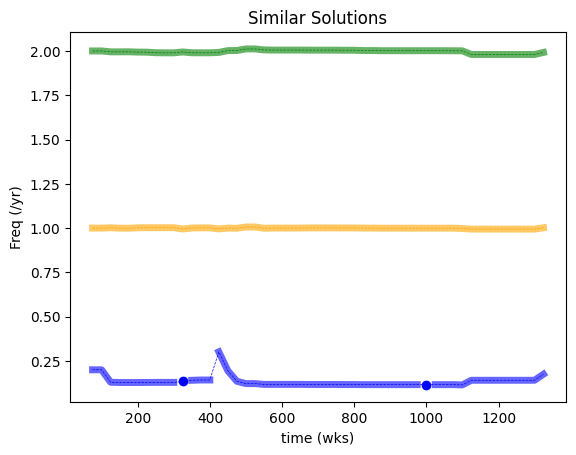

In [21]:
group_idx = nsdmd.group_by_similarity(model.freqs_, model.phis_, model.opt_stride/sr, \
                                      model.sim_thresh_freq, model.sim_thresh_phi_amp)

x_extent = np.mean(model.windows_, axis=1)
colors = ['blue', 'orange', 'green', 'red',\
          'blue', 'orange', 'green', 'red',\
          'blue', 'orange', 'green', 'red']
for i in range(len(group_idx))[:24:2]:
    plt.plot(x_extent, model.freqs_[:,i], linestyle='dashed', color=colors[i//2], linewidth=0.5)
    for g in group_idx[i]:
        if(len(g)>1):
            plt.plot(x_extent[g], model.freqs_[g,i], color=colors[i//2], linewidth=5, alpha=0.6)
        else:
            plt.scatter(x_extent[g], model.freqs_[g,i], color=colors[i//2])
plt.xlabel('time (wks)')
plt.ylabel('Freq (/yr)')
plt.title('Similar Solutions')

In [22]:
model.fit_reduction(x, len(t), sr)

Gathering modes...
Found 6 modes
Number of modes: 6/6, stopping at 0
Number of modes: 5/6, stopping at 0
Number of modes: 4/6, stopping at 0
Number of modes: 3/6, stopping at 0
Number of modes: 2/6, stopping at 0
Number of modes: 1/6, stopping at 0


Text(0, 0.5, 'Cosine Distance')

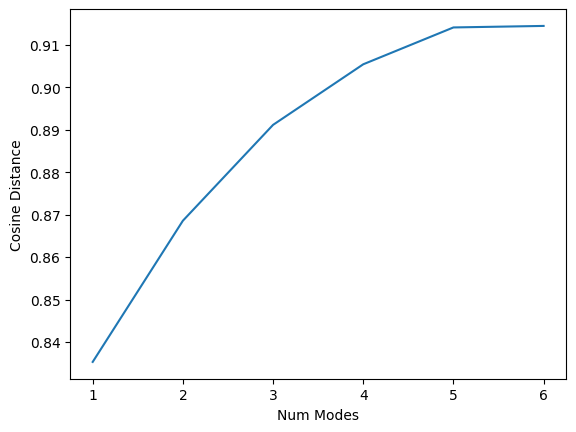

In [23]:
plt.plot(model.num_modes_, model.errors_)
plt.xlabel('Num Modes')
plt.ylabel('Cosine Distance')

In [24]:
model.fit_f(x, len(t), sr, 5)

In [25]:
model.freq_mean_

array([0.13403257, 0.17619954, 0.12271817, 0.99946179, 1.99624082])

Text(0, 0.5, 'F(t)')

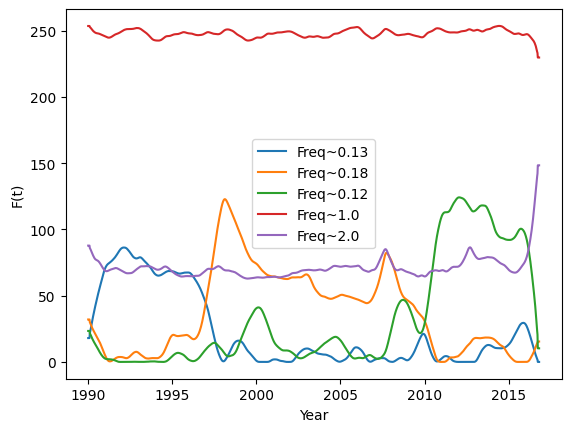

In [26]:
for i in range(len(model.f_hat_)):
    plt.plot(t+1990, model.f_hat_[i], label='Freq~'+str(round(model.freq_mean_[i],2)))

plt.legend()
plt.xlabel('Year')
plt.ylabel('F(t)')


In [27]:
freq_, phi_ = model.get_freq_and_phi(len(t), sr)

(-0.5, 359.5, 179.5, -0.5)

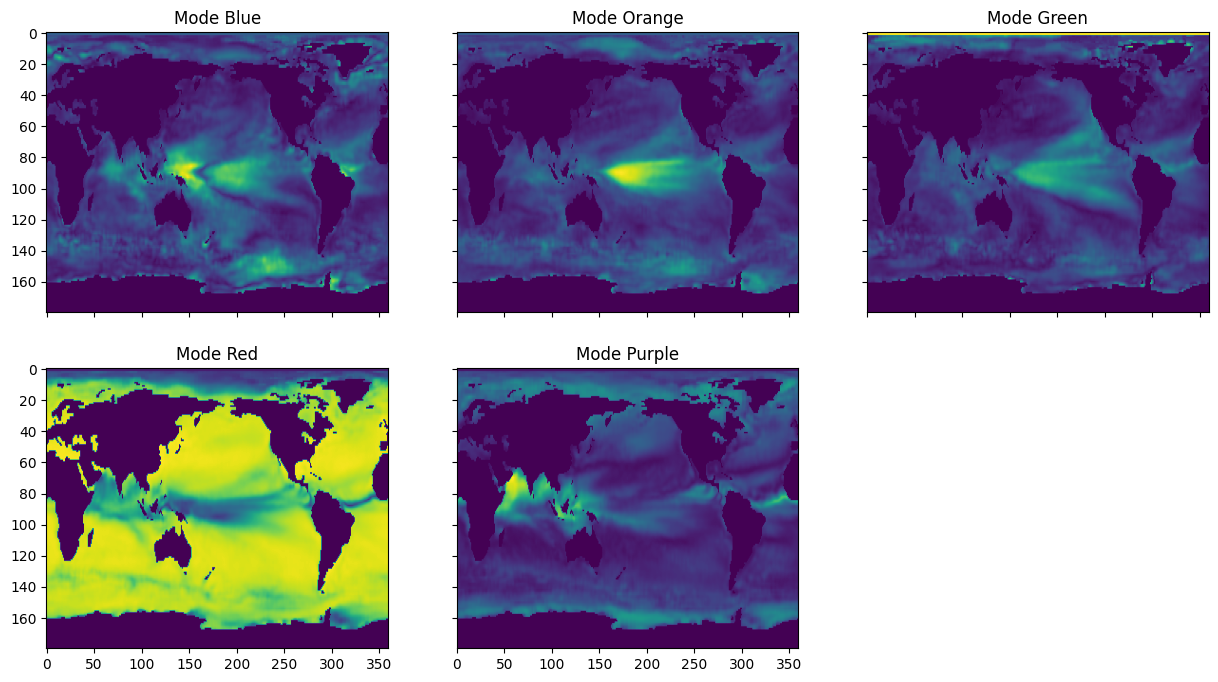

In [28]:
fig, ax = plt.subplots(2, 3, figsize=(15,8), sharex=True, sharey=True)

colors=['Blue', 'Orange', 'Green', 'Red', 'Purple']
vmin = 0
vmax = 0.01

for i in range(3):
    temp = np.abs(phi_[i])[model.f_hat_[i]>np.mean(model.f_hat_[i])]
    temp = np.mean(temp, axis=0)

    temp2 = np.zeros(len(mask_1d))
    temp2[idx_not_land] = temp
    temp2 = temp2.reshape((mask.shape[0], mask.shape[1]))

    ax[0,i].imshow(temp2, aspect='auto')#, vmin=vmin, vmax=vmax)
    ax[0,i].set_title('Mode '+colors[i])

for i in range(2):
    temp = np.zeros(len(mask_1d))
    temp[idx_not_land] = np.abs(model.phi_mean_[i+3])
    temp = temp.reshape((mask.shape[0], mask.shape[1]))

    ax[1,i].imshow(temp, aspect='auto')#, vmin=vmin, vmax=vmax)
    ax[1,i].set_title('Mode '+colors[i+3])

ax[1,2].axis('off')

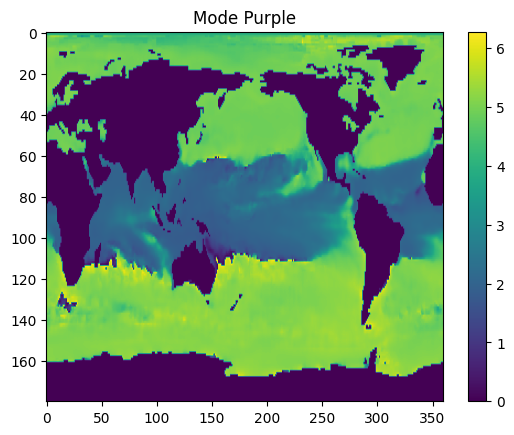

In [29]:
mode_idx = 4

temp = np.zeros(len(mask_1d))
temp[idx_not_land] = (np.angle(model.phi_mean_[mode_idx])) % (2*np.pi)
temp = temp.reshape((mask.shape[0], mask.shape[1]))

plt.title('Mode '+colors[mode_idx])
plt.imshow(temp, aspect='auto')
plt.colorbar()

# Reconstruction of Earlier Modes

In [30]:
temp = x.T[(t>8)][:4*12:4]

norm = 5
vmax=np.max(np.abs(temp))/norm

In [31]:
x_rec = model.transform(x, len(t), sr)

temp = np.zeros((len(mask_1d), x_rec.shape[1]))
temp[idx_not_land] = x_rec
temp = temp.T.reshape((1400, mask.shape[0], mask.shape[1]))

In [32]:
temp2 = temp[(t>8)][:4*12:4]
temp_t = t[(t>8)][:4*12:4]+1990

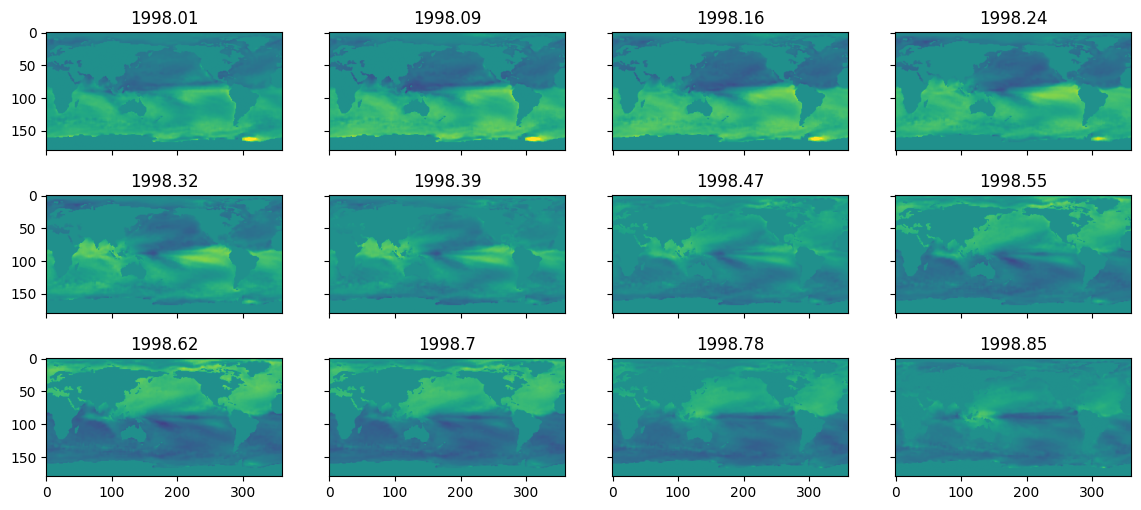

In [33]:
fig, ax = plt.subplots(3, 4, figsize=(14,6), sharex=True, sharey=True)

for i in range(3):
    for j in range(4):
        idx = j+4*i
        ax[i,j].imshow(
            temp2[idx]*mask,
            vmin=-vmax,
            vmax=vmax
        )
        ax[i,j].set_title(str(round(temp_t[idx],2)))

# Reconstruction based solely on El Nino mode

In [34]:
soln, _, _ = nsdmd.get_soln(
    model.freqs_,
    model.phis_,
    model.idx_hat_,
    len(t),
    model.windows_,
    model.drift_N,
    sr,
)
x_rec = nsdmd.get_reconstruction(soln[1:2], model.f_hat_[1:2])

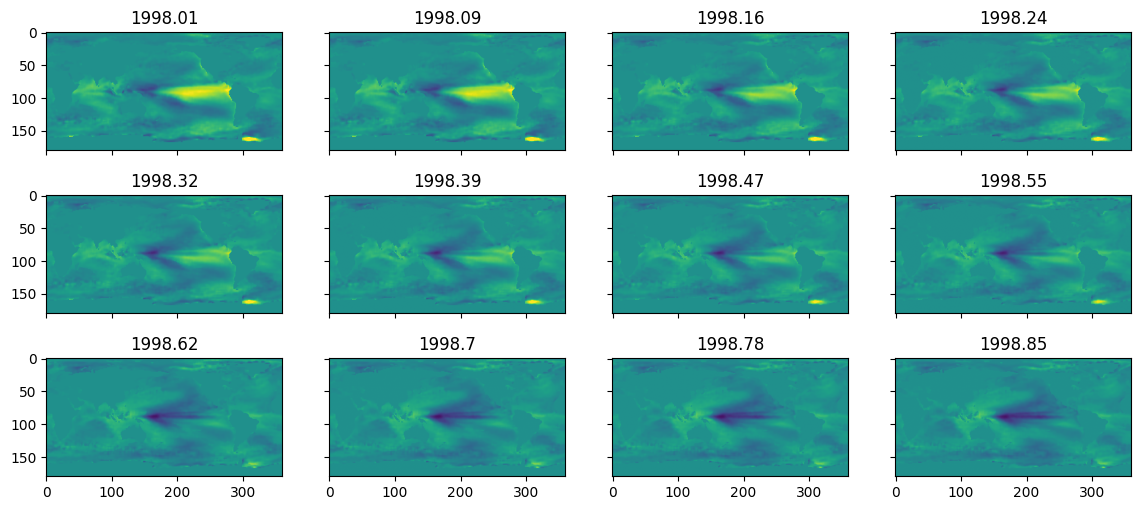

In [35]:
temp = np.zeros((len(mask_1d), x_rec.shape[1]))
temp[idx_not_land] = x_rec
temp = temp.T.reshape((1400, mask.shape[0], mask.shape[1]))

temp2 = temp[(t>8)][:4*12:4]
temp_t = t[(t>8)][:4*12:4]+1990

fig, ax = plt.subplots(3, 4, figsize=(14,6), sharex=True, sharey=True)

for i in range(3):
    for j in range(4):
        idx = j+4*i
        ax[i,j].imshow(
            temp2[idx]*mask,
            vmin=-vmax/2,
            vmax=vmax/2
        )
        ax[i,j].set_title(str(round(temp_t[idx],2)))

# Combining into Single Figure

In [36]:
soln, _, _ = nsdmd.get_soln(
    model.freqs_,
    model.phis_,
    model.idx_hat_,
    len(t),
    model.windows_,
    model.drift_N,
    sr,
)
x_rec = nsdmd.get_reconstruction(soln[1:2], model.f_hat_[1:2])

In [37]:
from matplotlib.pyplot import Rectangle
import matplotlib.colors as mcolors

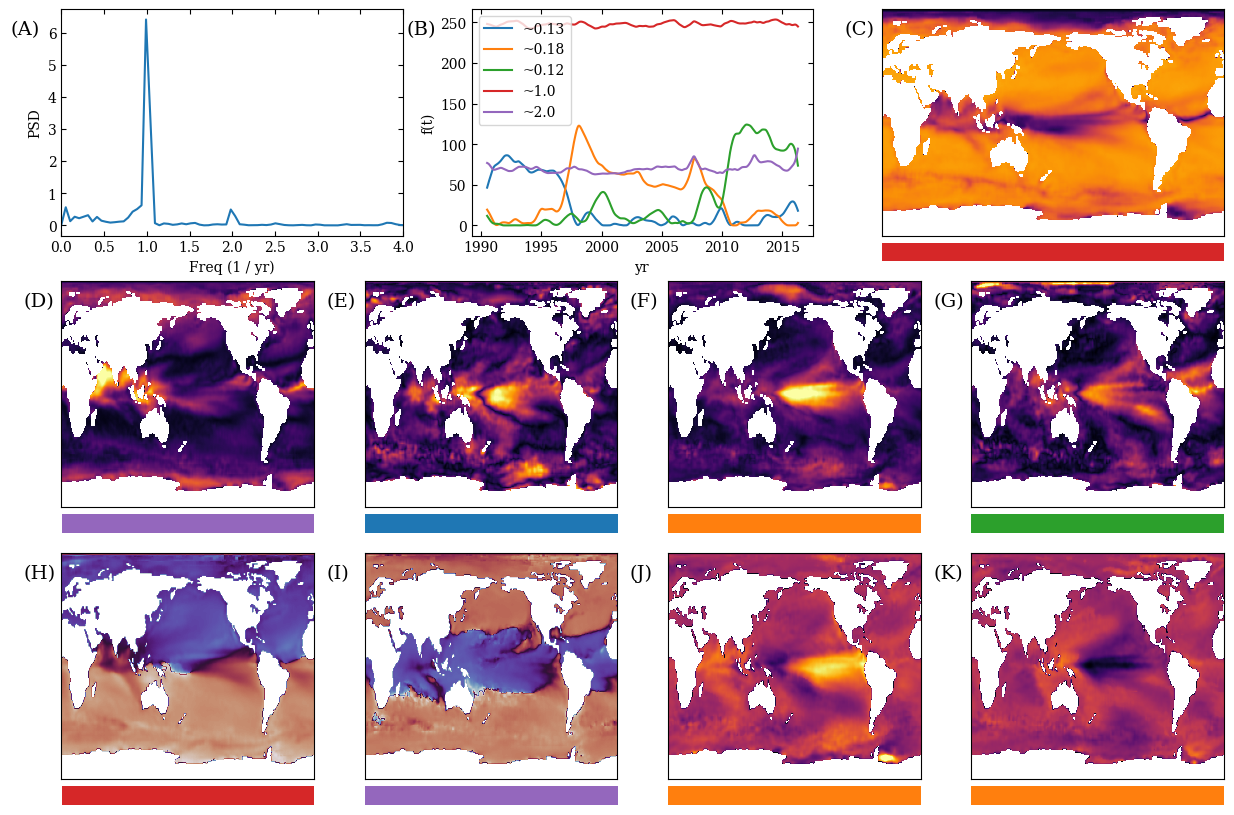

In [41]:
#Plot Figure

plt.rc('font', family='serif')
fig = plt.figure(figsize=(15,10))

#PSD
ax = fig.add_subplot(331)
ax.tick_params(axis='both',which='both',direction='in',right=True,top=True)

ax.plot(psd_f, psd_p)
ax.set_xlim(0,4)
# cax = ax.imshow(x, aspect='auto', vmin=-0.5, vmax=0.5)
# cbar = fig.colorbar(cax)
# cbar.set_label('Amp (A.U.)', rotation=270)
ax.set_xlabel('Freq (1 / yr)')
ax.set_ylabel('PSD')
ax.text(-0.15, 0.95, '(A)', transform=ax.transAxes, fontsize=14, verticalalignment='top')

#f(t)
ax = fig.add_subplot(332)
ax.tick_params(axis='both',which='both',direction='in',right=True,top=True)

for i in range(len(model.f_hat_)):
    ax.plot(t[26:-26]+1990, model.f_hat_[i][26:-26], label='~'+str(round(model.freq_mean_[i],2)))

ax.legend()
ax.set_xlabel('yr')
ax.set_ylabel('f(t)')
ax.text(-0.19, 0.95, '(B)', transform=ax.transAxes, fontsize=14, verticalalignment='top')


#Main Mode
vmin = 0
vmax = 0.007

colors1 = plt.cm.binary(np.linspace(0., 1, 2))[:1]
colors2 = plt.cm.inferno(np.linspace(0, 1, 255))

colors_imshow = np.vstack((colors1, colors2))
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors_imshow)

ax = fig.add_subplot(333)
ax.tick_params(axis='both',which='both',direction='in',right=True,top=True)

temp = np.zeros(len(mask_1d))-1
temp[idx_not_land] = np.abs(model.phi_mean_[3])
temp = temp.reshape((mask.shape[0], mask.shape[1]))

ax.imshow(temp, aspect='auto', vmin=vmin, vmax=vmax, cmap=mymap)
ax.set_xticks([])
ax.set_yticks([])
ax.add_patch(Rectangle((0,mask.shape[0]+5), mask.shape[1], 15, facecolor='tab:red',
                              clip_on=False))
ax.text(-0.11, 0.95, '(C)', transform=ax.transAxes, fontsize=14, verticalalignment='top')

#Other Modes
colors = ['tab:purple', 'tab:blue', 'tab:orange', 'tab:green']
temp2 = ['(D)', '(E)', '(F)', '(G)']
vmin = 0
vmax = 0.015

for i,j in enumerate([4,0,1,2]):
    ax = fig.add_subplot(3,4,5+i)
    ax.tick_params(axis='both',which='both',direction='in',right=True,top=True)

    temp = np.zeros(len(mask_1d))-1
    temp[idx_not_land] = np.abs(model.phi_mean_[j])
    temp = temp.reshape((mask.shape[0], mask.shape[1]))

    ax.imshow(temp, aspect='auto', vmin=vmin, vmax=vmax, cmap=mymap)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.add_patch(Rectangle((0,mask.shape[0]+5), mask.shape[1], 15, facecolor=colors[i],
                              clip_on=False))
    ax.text(-0.15, 0.95, temp2[i], transform=ax.transAxes, fontsize=14, verticalalignment='top')


#Mode Phases
colors = ['tab:red', 'tab:purple']
temp2 = ['(H)', '(I)']
vmin = 0
vmax = 2*np.pi

colors1 = plt.cm.binary(np.linspace(0., 1, 2))[:1]
colors2 = plt.cm.twilight(np.linspace(0, 1, 255))

colors_imshow = np.vstack((colors1, colors2))
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors_imshow)

for i,j in enumerate([3,4]):
    ax = fig.add_subplot(3,4,9+i)
    ax.tick_params(axis='both',which='both',direction='in',right=True,top=True)

    temp = np.zeros(len(mask_1d)) - 1
    temp[idx_not_land] = (np.angle(model.phi_mean_[j])) % (2*np.pi)
    temp = temp.reshape((mask.shape[0], mask.shape[1]))

    ax.imshow(temp, aspect='auto', vmin=vmin, vmax=vmax, cmap=mymap)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.add_patch(Rectangle((0,mask.shape[0]+5), mask.shape[1], 15, facecolor=colors[i],
                              clip_on=False))
    ax.text(-0.15, 0.95, temp2[i], transform=ax.transAxes, fontsize=14, verticalalignment='top')


#Mode Phases
colors = ['tab:orange', 'tab:orange']
temp2 = ['(J)', '(K)']
vmin = 0
vmax = 4

colors1 = plt.cm.binary(np.linspace(0., 1, 2))[:1]
colors2 = plt.cm.inferno(np.linspace(0, 1, 255))

colors_imshow = np.vstack((colors1, colors2))
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors_imshow)

times_investigated = []

for i,j in enumerate([8,9]):
    ax = fig.add_subplot(3,4,11+i)
    ax.tick_params(axis='both',which='both',direction='in',right=True,top=True)

    idx = np.argwhere(t>j)[0,0]#[:4*12:4,0][j]

    temp = np.zeros(len(mask_1d)) - 1
    temp[idx_not_land] = x_rec[:,idx] - np.min(x_rec)
    temp = temp.T.reshape((mask.shape[0], mask.shape[1]))

    times_investigated.append(idx)

    ax.imshow(temp, aspect='auto', vmin=vmin, vmax=vmax, cmap=mymap)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.add_patch(Rectangle((0,mask.shape[0]+5), mask.shape[1], 15, facecolor=colors[i],
                              clip_on=False))
    ax.text(-0.15, 0.95, temp2[i], transform=ax.transAxes, fontsize=14, verticalalignment='top')


# plt.savefig('figs/sst.svg', bbox_inches='tight')

plt.show()

# Reconstruction Error

In [42]:
x_rec = model.transform(x, len(t), sr)

In [43]:
nsdmd.get_reconstruction_error(x, x_rec)

0.9168344344501114